# Birth order effects in SSC

Double-checking http://slatestarcodex.com/2018/01/08/fight-me-psychologists-birth-order-effects-exist-and-are-very-strong/


In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib as mpl; mpl.rcParams.update({'nbagg.transparent': False, 'figure.facecolor': 'white'})

In [166]:
url = 'http://slatestarcodex.com/Stuff/ssc2018public.xlsx'

# Passing URL directly to pd.read_excel does not work (SSC website does not allow automatic download?),
# so we have to emulate browser headers

from urllib.request import Request, urlopen
myHeaders = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/55.0.2883.87 Safari/537.36', 'Referer': 'https://www.nseindia.com', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'}
url_request = Request(url, headers=myHeaders)
data = urlopen(url_request)
ssc2018 = pd.read_excel(data)

# list(ssc2018)

In [157]:
age = pd.to_numeric(ssc2018['Age'], errors='coerce').values
gender = ssc2018['Gender'].values
obr = pd.to_numeric(ssc2018['OlderBrothers'], errors='coerce').values
ybr = pd.to_numeric(ssc2018['YoungerBrothers'], errors='coerce').values
osis = pd.to_numeric(ssc2018['OlderSisters'], errors='coerce').values
ysis = pd.to_numeric(ssc2018['YoungerSisters'], errors='coerce').values

<IPython.core.display.Javascript object>


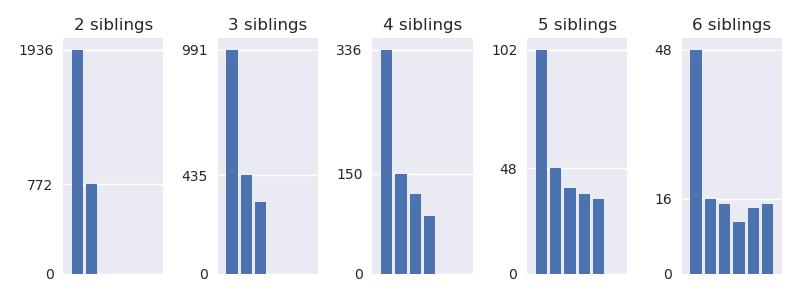

In [140]:
plt.figure(figsize=(8,3))
for sibnum in range(1,6):
    plt.subplot(1,5,sibnum)
    n = np.zeros(sibnum+1)
    for oldersibs in range(0,sibnum+1):
        n[oldersibs] = np.sum((obr + ybr + osis + ysis == sibnum) & (obr + osis == oldersibs))
    plt.bar(np.arange(sibnum+1)+1, n)
    plt.xlim([0, 7])
    plt.xticks([])
    plt.yticks([0, n[0], n[1]])
    plt.title(str(sibnum+1) + ' siblings')
plt.tight_layout()

<IPython.core.display.Javascript object>


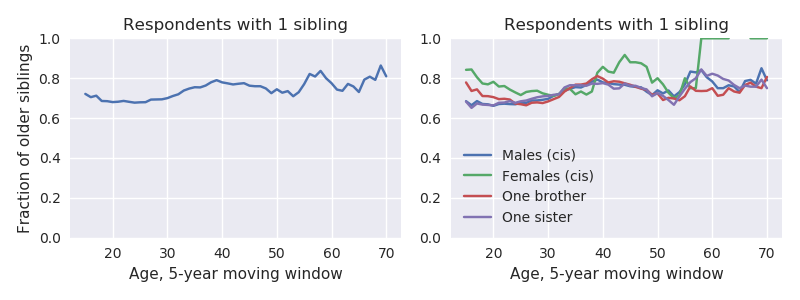

In [165]:
youngersibs = ybr + ysis
sib1 = obr + ybr + osis + ysis == 1

ages = np.arange(15,71)
fracs = np.zeros((len(ages),5))

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,a in enumerate(ages):
        fracs[i,0] = np.mean(youngersibs[sib1 & (np.abs(age-a)<5)])
        fracs[i,1] = np.mean(youngersibs[sib1 & (np.abs(age-a)<5) & (gender=='M (cisgender)')])
        fracs[i,2] = np.mean(youngersibs[sib1 & (np.abs(age-a)<5) & (gender=='F (cisgender)')])
        fracs[i,3] = np.mean(ybr[(ybr+obr==1) & (np.abs(age-a)<5)])
        fracs[i,4] = np.mean(ysis[(ysis+osis==1) & (np.abs(age-a)<5)])

plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(ages,fracs[:,0])
plt.ylim([0,1])
plt.xlabel('Age, 5-year moving window')
plt.ylabel('Fraction of older siblings')
plt.title('Respondents with 1 sibling')

plt.subplot(122)
plt.plot(ages,fracs[:,1:])
plt.ylim([0,1])
plt.xlabel('Age, 5-year moving window')
plt.title('Respondents with 1 sibling')
plt.legend(('Males (cis)', 'Females (cis)', 'One brother', 'One sister'))
plt.tight_layout()

[ 0.29372753  1.73767443]
[ 1.          0.41798138  0.31558739  0.29757331  0.29440411  0.29384656]


<IPython.core.display.Javascript object>


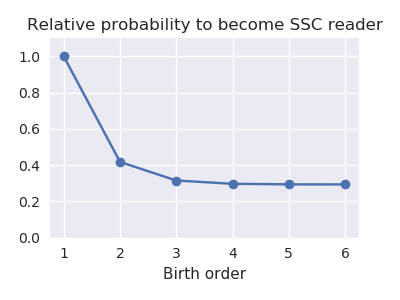

In [169]:
def logloss(w):
    c = w[0]
    b = w[1]
    ll = 0
    for sibnum in range(1,6):
        ps = (1-c)*np.exp(b*(1-np.arange(1, sibnum+2))) + c
        for oldersibs in range(0,sibnum+1):
            p = ps[oldersibs] / np.sum(ps)
            n = np.sum((obr + ybr + osis + ysis == sibnum) & (obr + osis == oldersibs))
            ll -= np.log(p) * n
    return ll  

beta = scipy.optimize.minimize(logloss, (.3, 2), method='Nelder-Mead').x
print(beta)

c = beta[0]
b = beta[1]
sibnum = 5
ps = (1-c)*np.exp(b*(1-np.arange(1, sibnum+2))) + c
print(ps)
plt.figure(figsize=(4,3))
plt.plot(np.arange(1,sibnum+2), ps, '-o')
#plt.plot(np.arange(1,sibnum+2), np.insert(pps,0,1)[:6], '-o')
#plt.legend(('Exponential model', 'Monotonically decreasing model'))
plt.ylim([0,1.1])
plt.xlabel('Birth order')
plt.title('Relative probability to become SSC reader')
plt.tight_layout()

[ 0.41634854  0.32577259  0.27879549  0.27879549  0.27879549]
[ 1.          0.41798138  0.31558739  0.29757331  0.29440411  0.29384656]


/home/localadmin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


<IPython.core.display.Javascript object>


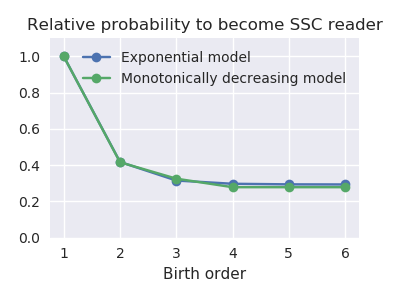

In [170]:
def logloss2(w):
    ll = 0
    for sibnum in range(1,6):
        ps = np.insert(w[:sibnum],0,1)
        for oldersibs in range(0,sibnum+1):
            p = ps[oldersibs] / np.sum(ps)
            n = np.sum((obr + ybr + osis + ysis == sibnum) & (obr + osis == oldersibs))
            ll -= np.log(p) * n
    return ll  

cons = ({'type': 'ineq', 'fun': lambda x: x[0] - x[1]},
        {'type': 'ineq', 'fun': lambda x: x[1] - x[2]},
        {'type': 'ineq', 'fun': lambda x: x[2] - x[3]},
        {'type': 'ineq', 'fun': lambda x: x[3] - x[4]})

pps = scipy.optimize.minimize(logloss2, (.3, .3, .3, .3, .3), method='SLSQP', constraints=cons).x

c = beta[0]
b = beta[1]
sibnum = 5
ps = (1-c)*np.exp(b*(1-np.arange(1, sibnum+2))) + c
print(ps)
plt.figure(figsize=(4,3))
plt.plot(np.arange(1,sibnum+2), ps, '-o')
plt.plot(np.arange(1,sibnum+2), np.insert(pps,0,1)[:6], '-o')
plt.legend(('Exponential model', 'Monotonically decreasing model'))
plt.ylim([0,1.1])
plt.xlabel('Birth order')
plt.title('Relative probability to become SSC reader')
plt.tight_layout()

<IPython.core.display.Javascript object>


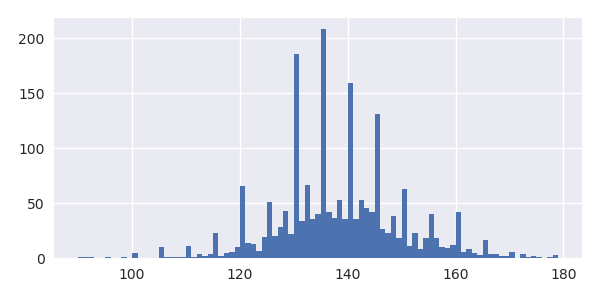

137.0
0.579037823486


In [168]:
# IQ distribution

plt.figure(figsize=(6,3))
iq = pd.to_numeric(ssc2018['IQ'], errors='coerce').values
iq = iq[~np.isnan(iq)]
plt.hist(iq, bins=np.arange(90,180))
plt.tight_layout()

print(np.median(iq)) # around 2.5 SDs above 100

from scipy import stats
a = 1 - stats.norm.cdf(2.5)
b = 1 - stats.norm.cdf(2.5 - .2)

print(a/b) # Predicted ratio if true d=.2 and cutoff is at 2.5